# CAPSTONE 3: TRADING with ML

In [1]:
# import libraries and packages
import os
import sys
module_path = os.path.abspath(os.path.join(r'C:\Users\matmi\Documents\Trading_w_ML_Capstone_3')) # or the path to your source code
sys.path.insert(0, module_path)

import pandas as pd
import numpy as np

from typing import List, Dict, Tuple, Callable, NewType, Any
from collections import OrderedDict, defaultdict

import datetime
import sklearn
import matplotlib.pyplot as plt

import technical_indicators as ti

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix,confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,f1_score, precision_recall_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# import necessary data from .csv file for EDA and testing a model

def load_stock_data(file_path: str="C:/Users/matmi/OneDrive/Documents/Algorithmic Trading Github/algorithmic-trading-with-python/data/eod/", 
                    ticker: str="AWU"):
    df = pd.read_csv(file_path + ticker + '.csv', parse_dates=['date'], index_col='date')
    return df

In [4]:
df_SP500 = pd.read_csv(r"C:\Users\matmi\OneDrive\Documents\Algorithmic Trading Github\algorithmic-trading-with-python\data\SPY.csv", parse_dates=['date'], index_col='date')
df_SP500.head(3)

,open,close,low,high,volume
date,,,,,
2010-01-04,112.37,113.33,111.51,113.39,118944600
2010-01-05,113.26,113.63,112.85,113.68,111579900
2010-01-06,113.52,113.71,113.43,113.99,116074400


In [5]:
def OBV(ser: pd.Series, vol_ser: pd.Series):
    """
    calculate the on balance volume of the close price for the dataframe
    """
    
    return pd.Series(np.where(ser > ser.shift(1), vol_ser, np.where(ser < ser.shift(1), -vol_ser, 0)).cumsum(), \
                     index=ser.index)

In [6]:
def create_train_test_dfs(ticker: str):
    """
    create the df of technical indicators for the RFclassifier model to train/test
    """
    # load the stock data
    df = load_stock_data(ticker=ticker)
    
    # calculate the rsi and related indicators for the df
    df['price_delta'], df['gain_ser'], df['loss_ser'], df['avg_gain_ser'], df['avg_loss_ser'], \
    df['rs_ser'], df['rsi_ser'] = ti.calculate_rsi(df['close'], 20)
    
    # create the MACD momentum indicator
    df['MACD'] = ti.calc_macd(df['close'])
    
    # create PROC indicator and rolling high/low indicators, etc...
    df['PROC'] = ti.PROC(df['close'], 9)
    df['rolling_low'] = ti.roll_low(ser=df['close'], n=14)
    df['rolling_high'] = ti.roll_high(ser=df['close'], n=14)
    df['k_percent'] = ti.k_percent(ser=df['close'], n=14)
    df['r_percent'] = ti.r_percent(ser=df['close'], n=14)
    df['MACD_EMA9'] = df['MACD'].ewm(span=9).mean()
    df['OBV'] = OBV(ser=df['close'], vol_ser=df['volume'])
    
    # create the Bollinger Bands
    df['upper_boll'] = ti.calc_bollinger_bands(df['close'])['upper']
    df['lower_boll'] = ti.calc_bollinger_bands(df['close'])['lower']
    
    # calculate the response variable
    df.loc['price_gain_tomorrow'] = df.loc[(df['price_delta'] < 0), 'price_gain_tomorrow'] = 0
    df.loc['price_gain_tomorrow'] = df.loc[(df['price_delta'] > 0), 'price_gain_tomorrow'] = 1
    df.loc['price_gain_tomorrow'] = df.loc[(df['price_delta'] == 0), 'price_gain_tomorrow'] = 0
    df.drop(index=['price_gain_tomorrow'], inplace=True)
    df['price_gain_tomorrow'] = df['price_gain_tomorrow'].shift(-1, fill_value=0)
    
    df.dropna(inplace=True)
    df['price_gain_tomorrow'] = df['price_gain_tomorrow'].apply(int)
    
    tr, tt = int(len(df)*0.8 - 20), int(len(df)*0.8 + 20)
    df_train = df.iloc[:tr]
    df_test = df.iloc[tt:]
    
    return df, df_train, df_test

In [7]:
%%time

from pathlib import Path
files = []
file_path = "C:/Users/matmi/OneDrive/Documents/Algorithmic Trading Github/algorithmic-trading-with-python/data/eod/"
dirs = os.listdir(file_path)
df = pd.DataFrame()
tick_list = {}
test_dfs = {}

for file in dirs:
    df, df_train, df_test = create_train_test_dfs(Path(file).stem)
    if len(df_train) < 1966:
        tick_list[Path(file).stem] = len(df_train)
    else:
        df = pd.concat([df, df_train], axis=0)
        test_dfs['df_'+Path(file).stem] = df_test

Wall time: 8.46 s


In [8]:
df

,open,close,low,high,volume,price_delta,gain_ser,loss_ser,avg_gain_ser,avg_loss_ser,...,PROC,rolling_low,rolling_high,k_percent,r_percent,MACD_EMA9,OBV,upper_boll,lower_boll,price_gain_tomorrow
date,,,,,,,,,,,,,,,,,,,,,
2010-02-22,170.87,167.10,166.45,170.87,669499,-2.54,0.00,-2.54,1.408597,-1.065377,...,0.125480,148.47,169.64,88.001889,11.998111,15.771059,4080980,175.677060,129.588940,0
2010-02-23,166.91,162.84,161.76,168.69,767502,-4.26,0.00,-4.26,0.939064,-2.130252,...,0.055278,148.47,169.64,67.879074,32.120926,14.858150,3313478,176.580602,130.766398,1
2010-02-24,164.27,163.59,162.34,166.05,798292,0.75,0.75,0.00,0.876043,-1.420168,...,0.068517,148.47,169.64,71.421823,28.578177,14.126266,4111770,177.320969,132.262031,0
2010-02-25,158.50,163.01,156.70,163.53,772301,-0.58,0.00,-0.58,0.584028,-1.140112,...,0.011040,148.47,169.64,68.682097,31.317903,13.185039,3339469,177.453986,134.581014,1
2010-02-26,163.00,165.30,160.62,165.97,551707,2.29,2.29,0.00,1.152686,-0.760074,...,0.022516,148.47,169.64,79.499291,20.500709,12.247729,3891176,177.198073,137.702927,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-04,355.65,353.08,353.08,360.55,734158,0.81,0.81,0.00,2.054872,-1.538749,...,0.033516,341.62,364.69,49.674902,50.325098,-14.319705,24377731,371.836891,336.592109,0
2017-12-05,351.26,351.66,350.53,354.60,500366,-1.42,0.00,-1.42,1.369915,-1.499166,...,0.026535,341.62,360.80,52.346194,47.653806,-13.360481,23877365,369.959726,336.903274,1
2017-12-06,351.58,352.56,349.79,354.69,669687,0.90,0.90,0.00,1.213277,-0.999444,...,0.015730,341.62,360.80,57.038582,42.961418,-12.362809,24547052,368.034496,337.417504,1


In [9]:
df.columns

Index(['open', 'close', 'low', 'high', 'volume', 'price_delta', 'gain_ser',
       'loss_ser', 'avg_gain_ser', 'avg_loss_ser', 'rs_ser', 'rsi_ser', 'MACD',
       'PROC', 'rolling_low', 'rolling_high', 'k_percent', 'r_percent',
       'MACD_EMA9', 'OBV', 'upper_boll', 'lower_boll', 'price_gain_tomorrow'],
      dtype='object')

In [10]:
tr, tt = int(len(df)*0.8 - 20), int(len(df)*0.8 + 20)
tr, tt

(3539, 3579)

# Random Forest Classifier

In [11]:
def train_model(df_train, df_test):
    
    # Create the target and features datasets
    X_tr = df_train[['rsi_ser', 'k_percent', 'r_percent', 'MACD', 'PROC', 'OBV', \
                     'price_delta', 'MACD_EMA9', 'upper_boll', 'lower_boll']] # removed  
    y_tr = df_train['price_gain_tomorrow']
    
    # No gridsearch; train on data using previous best params
#     params_ = ['max_features' = 5, 
#                 'max_depth' = 10, 
#                 'n_estimators' = 100,
#                 'min_samples_leaf' = 529
#                ]
    
    # Create best RFClassifier
    rf_model = RandomForestClassifier(max_features=5, max_depth=10, n_estimators=100, min_samples_leaf=529, random_state=123)
    rf_model.fit(X_tr, y_tr)
    
    return rf_model, X_tr, y_tr

In [12]:
%%time
rf_model, X_tr, y_tr = train_model(df_train=df, df_test=df_test)

Wall time: 602 ms


In [13]:
def predictions(rf_model, df_test, ticker, X_tr, y_tr):
    """
    
    """
    # create test target and features
    X_tt = df_test[['rsi_ser', 'k_percent', 'r_percent', 'MACD', 'PROC', 'OBV', \
                    'price_delta', 'MACD_EMA9', 'upper_boll', 'lower_boll']] 
    y_tt = df_test['price_gain_tomorrow']
    
    y_pred_rf = rf_model.predict(X_tt)
    # NEED TO SAVE CLASSIFICATION REPORTS
    ## SAVE predictions FOR EACH df IN A COMMON predictions_df or predictions_dict
    
    rocauc = roc_auc_score(y_tt,y_pred_rf)
    y_pred_rf_p = rf_model.predict_proba(X_tt)[:,1]
    rocauc_proba = roc_auc_score(y_tt,y_pred_rf_p)
    
    feature_import = rf_model.feature_importances_[:len(X_tr)]
    feature_import = feature_import*100
    
    # variables to save:
    # y_tt, X_tt, y_pred_rf, feature_import
    scores_dict = {ticker+'_y_tt': y_tt,
                   ticker+'_X_tt' : X_tt,
                   ticker+'_y_pred_rf' : y_pred_rf,
                   ticker+'_feature_import' : feature_import
                  }
    
    backtest_df = pd.DataFrame(data=zip(y_pred_rf, df_test['close'], df_SP500['close'][(len(df_SP500)-477):]), \
                               index=y_tt.index, columns=['buy_days', ticker+'_close', 'SPY'])
    
    backtest_df[ticker+'_gains_losses'] = backtest_df[ticker+'_close'] - backtest_df[ticker+'_close'].shift(1)
    backtest_df = backtest_df.fillna(0)
    
    # create floats of shares purchased based on a $100,000 investment
    shares_company_ticker = 1000 / backtest_df[ticker+'_close'][0]
    shares_SPY = 93000 / backtest_df['SPY'][0]
    
    # finish the backtest df 
    backtest_df.loc['returns'] = backtest_df.loc[(backtest_df['buy_days'].shift(1) == 1), 'returns'] = \
                                            backtest_df[ticker+'_gains_losses']*shares_company_ticker
    
    backtest_df.loc['returns'] = backtest_df.loc[(backtest_df['buy_days'].shift(1) == 0), 'returns'] = int(0)
    
    backtest_df['SPY_portfolio_series'] = backtest_df['SPY'] * shares_SPY
    backtest_df.drop(index=['returns'], inplace=True)
    
    portfolio_series = backtest_df['returns'].cumsum(axis=0) + backtest_df[ticker+'_close'][0]*shares_company_ticker
    
    portfolio_series_df = pd.DataFrame(data=portfolio_series, index=backtest_df.index).rename(columns={'returns': ticker+'_returns'})
    
    # create return_price_series df to save all company returns to compare with holding S&P500
#     portfolio_df.append(portfolio_series_df, axis=1)
    
    return portfolio_series_df, backtest_df, rocauc, rocauc_proba, scores_dict

In [14]:
%%time
from pathlib import Path
files = []
file_path = "C:/Users/matmi/OneDrive/Documents/Algorithmic Trading Github/algorithmic-trading-with-python/data/eod/"
dirs = os.listdir(file_path)
portfolio_df = pd.DataFrame()
port_series_df = pd.DataFrame()
bcktst_df = pd.DataFrame()
y_test_arr = []
y_pred_arr = []
X_test_df = pd.DataFrame()
rocauc = []
rocauc_proba = []
feature_importance = [0] * 10

for file in dirs:
    if ('df_'+Path(file).stem) in test_dfs:
        port_series_df, backtest_df, rocauc_, rocauc_proba_, scores_dict = predictions(rf_model=rf_model, \
                                                                          df_test=test_dfs['df_'+Path(file).stem], \
                                                                          ticker=Path(file).stem, X_tr=X_tr, y_tr=y_tr)
        portfolio_df = pd.concat([portfolio_df, port_series_df], axis=1)
        bcktst_df = pd.concat([bcktst_df, backtest_df], axis=1)
        rocauc.append(rocauc_)
        rocauc_proba.append(rocauc_proba_)
        feature_importance = feature_importance + scores_dict[Path(file).stem+'_feature_import']
        y_test_arr.extend(scores_dict[Path(file).stem+'_y_tt'].tolist())
        y_pred_arr.extend(scores_dict[Path(file).stem+'_y_pred_rf'].tolist())
        X_test_df = pd.concat([X_test_df, scores_dict[Path(file).stem+'_X_tt']], axis=0)

Wall time: 17.5 s


In [15]:
scoring_df = pd.DataFrame(data={'y_tt': y_test_arr, 'y_pred': y_pred_arr})
scoring_df

,y_tt,y_pred
0,1,1
1,1,1
2,1,1
3,1,1
4,0,1
...,...,...
44356,0,0
44357,1,1
44358,0,1
44359,1,1


In [16]:
rf_roc_auc = roc_auc_score(scoring_df["y_tt"],scoring_df["y_pred"])
rf_roc_auc

0.5070912623920104

In [17]:
print(classification_report(scoring_df["y_tt"], scoring_df["y_pred"], digits=4))

              precision    recall  f1-score   support

           0     0.4809    0.2832    0.3565     20765
           1     0.5368    0.7310    0.6190     23596

    accuracy                         0.5214     44361
   macro avg     0.5088    0.5071    0.4877     44361
weighted avg     0.5106    0.5214    0.4961     44361



Random Forest Confusion matrix


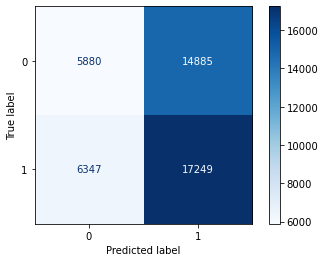

In [18]:
print("Random Forest Confusion matrix")
plot_confusion_matrix(rf_model, X_test_df, scoring_df['y_tt'], cmap=plt.cm.Blues)
plt.show()

In [19]:
portfolio_df['portfolio_sum'] = portfolio_df.sum(axis=1)
portfolio_df.dropna(inplace=True)

In [20]:
portfolio_df

,AWU_returns,AXC_returns,BMG_returns,CHWK_returns,CUU_returns,DLVY_returns,DVRL_returns,EHH_returns,EUZ_returns,EXY_returns,...,XZFM_returns,YPDA_returns,ZEA_returns,ZGL_returns,ZOE_returns,ZWH_returns,ZWNG_returns,ZXGV_returns,ZZQB_returns,portfolio_sum
date,,,,,,,,,,,,,,,,,,,,,
2018-02-09,1014.250066,1015.222766,1007.858255,1025.238249,1011.901194,1034.013864,1009.773202,999.435572,1010.670547,1009.001125,...,1014.836286,990.885268,1011.669875,1014.490543,1004.945598,1026.703524,1011.659479,1020.565328,992.866075,94308.235031
2018-02-12,1044.260573,1054.491686,1016.087182,1039.129381,1003.253564,1045.347602,1024.246494,1001.660082,1018.855341,1014.677616,...,1015.802469,1016.178649,1021.896054,1028.523490,1010.014837,1030.299777,1018.766970,1032.860768,1000.738972,95309.694791
2018-02-13,1060.218019,1053.231202,1004.373934,1052.980132,1013.656407,1052.987756,1027.678305,982.004715,1043.167212,1017.748312,...,1040.150295,978.238578,1043.792108,1035.539963,1013.105836,1029.199431,1018.048235,1037.455150,997.385175,95503.387719
2018-02-14,1094.661151,1065.836040,1024.686782,1048.174770,1020.934115,1052.987756,1049.015219,1000.796839,1067.357827,1017.060726,...,1060.526033,1012.418822,1070.620789,1022.422209,1022.873393,1026.703524,1010.301869,1065.240221,991.018645,96725.881829
2018-02-15,1039.696612,1074.853348,1040.255023,1080.116298,1018.750803,1052.987756,1050.134288,967.694811,1071.238026,1016.627078,...,1060.526033,988.492651,1085.298364,1047.589994,1033.382789,1039.961354,1037.294362,1075.785420,978.910869,97658.618580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1084.088521,1123.139574,1076.729187,1042.763689,1200.864763,1440.459927,1163.458669,516.750224,968.048988,936.675678,...,1377.305421,784.892332,1029.595765,1200.427090,1308.358061,1282.601111,1355.294681,922.551851,1172.294225,113478.797294
2019-12-26,1078.178356,1123.139574,1081.547928,1046.519141,1200.864763,1445.962356,1172.858848,511.836382,972.596096,942.930366,...,1377.305421,782.613649,1029.595765,1194.173276,1318.496538,1282.601111,1368.311771,926.358624,1172.294225,113716.931518
2019-12-27,1066.128185,1123.139574,1083.253021,1048.336295,1200.864763,1445.228699,1166.815876,503.735184,967.745847,927.506563,...,1377.305421,761.991569,1029.595765,1191.427700,1340.380811,1282.091195,1379.412234,920.626586,1172.464757,113751.713393


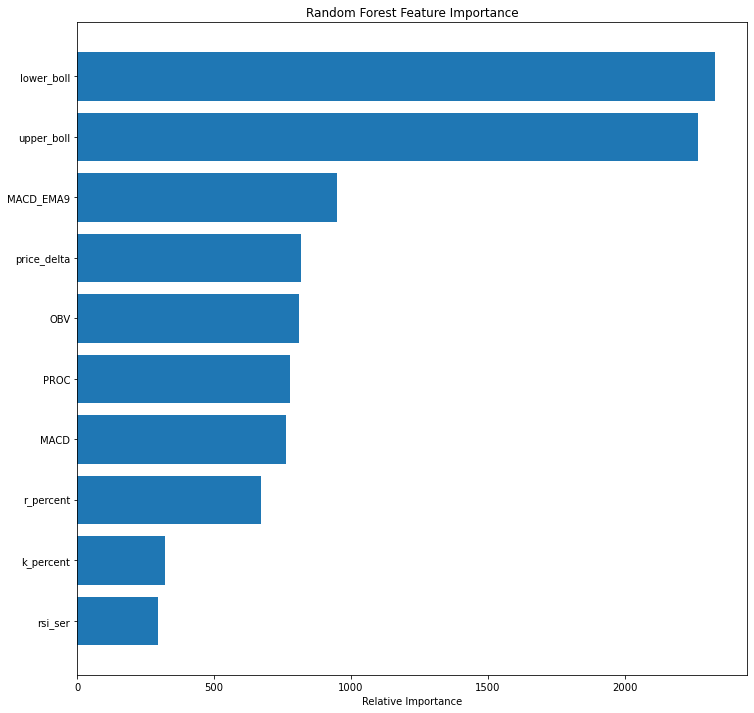

In [21]:
feature_import = (feature_importance/len(test_dfs))*100

sorted_idx = np.argsort(feature_import)
pos = np.arange(sorted_idx.shape[0])
sorted_idx.size
plt.figure(figsize=(12,12))
plt.barh(pos, feature_import[sorted_idx], align='center')
plt.yticks(pos, ['rsi_ser', 'k_percent', 'r_percent', 'MACD', 'PROC', 'OBV', \
                 'price_delta', 'MACD_EMA9', 'upper_boll', 'lower_boll'])
plt.xlabel('Relative Importance')
plt.title('Random Forest Feature Importance')
plt.show()

In [22]:
portfolio_df_rf = portfolio_df

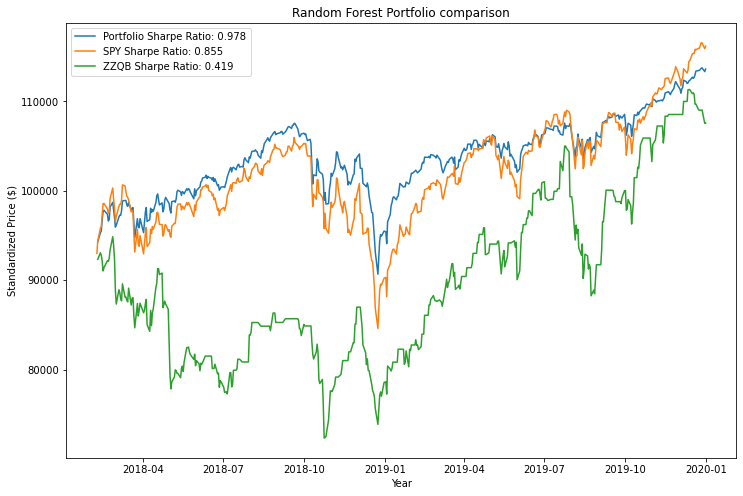

In [23]:
# plot sharpe ratio
# AWU_sharpe = ti.calc_sharpe_ratio(price_series=df_AWU['close'])
# BMG_sharpe = ti.calc_sharpe_ratio(price_series=df_BMG['close'])
# CUU_sharpe = ti.calc_sharpe_ratio(price_series=df_CUU['close'])

plt.figure(figsize=(12,8))
plt.plot(portfolio_df.index, portfolio_df['portfolio_sum'], label = "Portfolio Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(portfolio_df['portfolio_sum']), 3))
plt.plot(backtest_df.index, backtest_df['SPY_portfolio_series'], label = "SPY Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(backtest_df['SPY_portfolio_series']), 3))
plt.plot(portfolio_df.index, portfolio_df['ZZQB_returns']*93, label = "ZZQB Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(portfolio_df['ZZQB_returns']), 3))
plt.xlabel("Year")
plt.ylabel("Standardized Price ($)")
plt.title("Random Forest Portfolio comparison")
plt.legend()
plt.show()

# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
def lr_train_model(df_train, df_test):
    
    # Create the target and features datasets
    X_tr = df_train[['rsi_ser', 'k_percent', 'r_percent', 'MACD', 'PROC', 'OBV', \
                     'price_delta', 'MACD_EMA9', 'upper_boll', 'lower_boll']] # removed  
    y_tr = df_train['price_gain_tomorrow']
    
    # Create default Logistic Regression
    lr_model = LogisticRegression(random_state=123)
    lr_model.fit(X_tr, y_tr)
    
    return lr_model, X_tr, y_tr

# model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X, y)

In [26]:
%%time
lr_model, X_tr, y_tr = lr_train_model(df_train=df, df_test=df_test)

Wall time: 18 ms


In [27]:
def lr_predictions(lr_model, df_test, ticker, X_tr, y_tr):
    """
    
    """
    # create test target and features
    X_tt = df_test[['rsi_ser', 'k_percent', 'r_percent', 'MACD', 'PROC', 'OBV', \
                    'price_delta', 'MACD_EMA9', 'upper_boll', 'lower_boll']] 
    y_tt = df_test['price_gain_tomorrow']
    
    y_pred_lr = lr_model.predict(X_tt)
    # NEED TO SAVE CLASSIFICATION REPORTS
    ## SAVE predictions FOR EACH df IN A COMMON predictions_df or predictions_dict
    
    rocauc = roc_auc_score(y_tt,y_pred_lr)
    y_pred_lr_p = lr_model.predict_proba(X_tt)[:,1]
    rocauc_proba = roc_auc_score(y_tt,y_pred_lr_p)

    
    # variables to save:
    # y_tt, X_tt, y_pred_lr
    scores_dict = {ticker+'_y_tt': y_tt,
                   ticker+'_X_tt' : X_tt,
                   ticker+'_y_pred_lr' : y_pred_lr
                  }
    
    backtest_df = pd.DataFrame(data=zip(y_pred_lr, df_test['close'], df_SP500['close'][(len(df_SP500)-477):]), \
                               index=y_tt.index, columns=['buy_days', ticker+'_close', 'SPY'])
    
    backtest_df[ticker+'_gains_losses'] = backtest_df[ticker+'_close'] - backtest_df[ticker+'_close'].shift(1)
    backtest_df = backtest_df.fillna(0)
    
    # create floats of shares purchased based on a $100,000 investment
    shares_company_ticker = 1000 / backtest_df[ticker+'_close'][0]
    shares_SPY = 93000 / backtest_df['SPY'][0]
    
    # finish the backtest df 
    backtest_df.loc['returns'] = backtest_df.loc[(backtest_df['buy_days'].shift(1) == 0), 'returns'] = int(0)
    
    backtest_df.loc['returns'] = backtest_df.loc[(backtest_df['buy_days'].shift(1) == 1), 'returns'] = \
                                            backtest_df[ticker+'_gains_losses']*shares_company_ticker
    
    backtest_df['SPY_portfolio_series'] = backtest_df['SPY'] * shares_SPY
    backtest_df.drop(index=['returns'], inplace=True)
    
    portfolio_series = backtest_df['returns'].cumsum(axis=0) + backtest_df[ticker+'_close'][0]*shares_company_ticker
    
    portfolio_series_df = pd.DataFrame(data=portfolio_series, index=backtest_df.index).rename(columns={'returns': ticker+'_returns'})

    # create return_price_series df to save all company returns to compare with holding S&P500
#     portfolio_df.append(portfolio_series_df, axis=1)
    
    return portfolio_series_df, backtest_df, rocauc, rocauc_proba, scores_dict

In [28]:
%%time
from pathlib import Path
files = []
file_path = "C:/Users/matmi/OneDrive/Documents/Algorithmic Trading Github/algorithmic-trading-with-python/data/eod/"
dirs = os.listdir(file_path)
portfolio_df = pd.DataFrame()
port_series_df = pd.DataFrame()
bcktst_df = pd.DataFrame()
y_test_arr = []
y_pred_arr = []
X_test_df = pd.DataFrame()
rocauc = []
rocauc_proba = []

for file in dirs:
    if ('df_'+Path(file).stem) in test_dfs:
        port_series_df, backtest_df, rocauc_, rocauc_proba_, scores_dict = lr_predictions(lr_model=lr_model, \
                                                                          df_test=test_dfs['df_'+Path(file).stem], \
                                                                          ticker=Path(file).stem, X_tr=X_tr, y_tr=y_tr)
        portfolio_df = pd.concat([portfolio_df, port_series_df], axis=1)
        bcktst_df = pd.concat([bcktst_df, backtest_df], axis=1)
        rocauc.append(rocauc_)
        rocauc_proba.append(rocauc_proba_)
        y_test_arr.extend(scores_dict[Path(file).stem+'_y_tt'].tolist())
        y_pred_arr.extend(scores_dict[Path(file).stem+'_y_pred_lr'].tolist())
        X_test_df = pd.concat([X_test_df, scores_dict[Path(file).stem+'_X_tt']], axis=0)

Wall time: 13.4 s


In [29]:
scoring_df = pd.DataFrame(data={'y_tt': y_test_arr, 'y_pred': y_pred_arr})
scoring_df

,y_tt,y_pred
0,1,0
1,1,0
2,1,0
3,1,0
4,0,0
...,...,...
44356,0,1
44357,1,1
44358,0,1
44359,1,1


In [30]:
lr_roc_auc = roc_auc_score(scoring_df["y_tt"],scoring_df["y_pred"])

In [31]:
print(classification_report(scoring_df["y_tt"], scoring_df["y_pred"], digits=4))

              precision    recall  f1-score   support

           0     0.4760    0.1153    0.1857     20765
           1     0.5329    0.8883    0.6662     23596

    accuracy                         0.5265     44361
   macro avg     0.5045    0.5018    0.4259     44361
weighted avg     0.5063    0.5265    0.4413     44361



Logistic Regression Confusion matrix


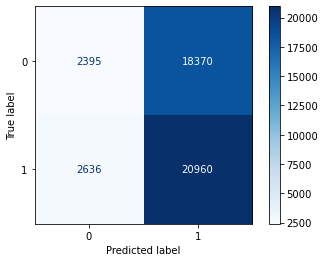

In [32]:
print("Logistic Regression Confusion matrix")
plot_confusion_matrix(lr_model, X_test_df, scoring_df['y_tt'], cmap=plt.cm.Blues)
plt.show()

In [33]:
portfolio_df['portfolio_sum'] = portfolio_df.sum(axis=1)
portfolio_df.dropna(inplace=True)

In [34]:
portfolio_df

,AWU_returns,AXC_returns,BMG_returns,CHWK_returns,CUU_returns,DLVY_returns,DVRL_returns,EHH_returns,EUZ_returns,EXY_returns,...,XZFM_returns,YPDA_returns,ZEA_returns,ZGL_returns,ZOE_returns,ZWH_returns,ZWNG_returns,ZXGV_returns,ZZQB_returns,portfolio_sum
date,,,,,,,,,,,,,,,,,,,,,
2018-02-09,1000.000000,1015.222766,1007.858255,1000.000000,1011.901194,1034.013864,1009.773202,999.435572,1000.0,1009.001125,...,1014.836286,1000.0,1011.669875,1014.490543,1004.945598,1026.703524,1011.659479,1020.565328,992.866075,94281.990184
2018-02-12,1000.000000,1054.491686,1016.087182,1013.891132,1003.253564,1045.347602,1024.246494,1001.660082,1000.0,1014.677616,...,1015.802469,1000.0,1021.896054,1028.523490,1010.014837,1030.299777,1018.766970,1032.860768,1000.738972,95111.840781
2018-02-13,1000.000000,1053.231202,1004.373934,1027.741883,1013.656407,1052.987756,1027.678305,982.004715,1000.0,1017.748312,...,1040.150295,1000.0,1043.792108,1035.539963,1013.105836,1029.199431,1018.048235,1037.455150,997.385175,95294.365321
2018-02-14,1000.000000,1065.836040,1024.686782,1022.936521,1020.934115,1056.339810,1049.015219,1000.796839,1000.0,1017.060726,...,1060.526033,1000.0,1070.620789,1022.422209,1022.873393,1026.703524,1010.301869,1065.240221,991.018645,96226.884730
2018-02-15,1000.000000,1074.853348,1040.255023,1054.878049,1018.750803,1047.194394,1050.134288,967.694811,1000.0,1016.627078,...,1081.288245,1000.0,1085.298364,1047.589994,1033.382789,1039.961354,1037.294362,1075.785420,978.910869,97200.854888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,960.927239,1157.754400,1065.683149,1033.233726,1147.737489,1369.649362,1218.815279,536.571599,1000.0,904.984217,...,1675.254965,1000.0,1049.205967,1173.428920,1622.403561,1188.481254,1355.614119,922.551851,1069.491814,111578.968954
2019-12-26,960.927239,1164.105299,1070.501890,1036.989178,1156.684790,1375.151791,1228.215458,536.571599,1000.0,911.238905,...,1680.730005,1000.0,1061.477382,1167.175107,1632.542038,1185.019189,1368.631209,926.358624,1068.695998,111976.780169
2019-12-27,960.927239,1164.880981,1072.206983,1038.806332,1155.700158,1374.418134,1222.172486,536.571599,1000.0,895.815102,...,1676.027912,1000.0,1056.304139,1164.429530,1654.426311,1184.509272,1379.731672,920.626586,1068.866530,112016.755672


In [35]:
portfolio_df_lr = portfolio_df

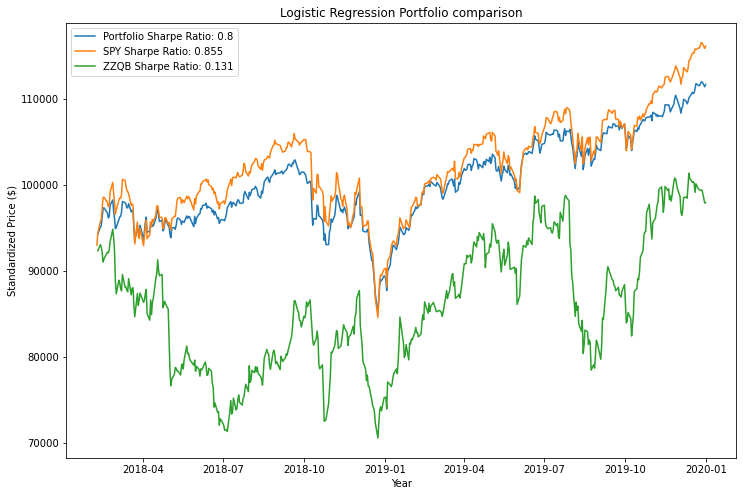

In [36]:
# plot sharpe ratio
# AWU_sharpe = ti.calc_sharpe_ratio(price_series=df_AWU['close'])
# BMG_sharpe = ti.calc_sharpe_ratio(price_series=df_BMG['close'])
# CUU_sharpe = ti.calc_sharpe_ratio(price_series=df_CUU['close'])

plt.figure(figsize=(12,8))
plt.plot(portfolio_df.index, portfolio_df['portfolio_sum'], label = "Portfolio Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(portfolio_df['portfolio_sum']), 3))
plt.plot(backtest_df.index, backtest_df['SPY_portfolio_series'], label = "SPY Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(backtest_df['SPY_portfolio_series']), 3))
plt.plot(portfolio_df.index, portfolio_df['ZZQB_returns']*93, label = "ZZQB Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(portfolio_df['ZZQB_returns']), 3))
plt.xlabel("Year")
plt.ylabel("Standardized Price ($)")
plt.title("Logistic Regression Portfolio comparison")
plt.legend()
plt.show()

# Gaussian Naive-Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

In [38]:
def gnb_train_model(df_train, df_test):
    
    # Create the target and features datasets
    X_tr = df_train[['rsi_ser', 'k_percent', 'r_percent', 'MACD', 'PROC', 'OBV', \
                     'price_delta', 'MACD_EMA9', 'upper_boll', 'lower_boll']] # removed  
    y_tr = df_train['price_gain_tomorrow']
    
    # Create default Logistic Regression
    gnb_model = GaussianNB()
    gnb_model.fit(X_tr, y_tr)
    
    return gnb_model, X_tr, y_tr

# model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X, y)

In [39]:
%%time
gnb_model, X_tr, y_tr = gnb_train_model(df_train=df, df_test=df_test)

Wall time: 7 ms


In [40]:
def gnb_predictions(gnb_model, df_test, ticker, X_tr, y_tr):
    """
    
    """
    # create test target and features
    X_tt = df_test[['rsi_ser', 'k_percent', 'r_percent', 'MACD', 'PROC', 'OBV', \
                    'price_delta', 'MACD_EMA9', 'upper_boll', 'lower_boll']] 
    y_tt = df_test['price_gain_tomorrow']
    
    y_pred_gnb = gnb_model.predict(X_tt)
    # NEED TO SAVE CLASSIFICATION REPORTS
    ## SAVE predictions FOR EACH df IN A COMMON predictions_df or predictions_dict
    
    rocauc = roc_auc_score(y_tt,y_pred_gnb)
    y_pred_gnb_p = gnb_model.predict_proba(X_tt)[:,1]
    rocauc_proba = roc_auc_score(y_tt,y_pred_gnb_p)

    
    # variables to save:
    # y_tt, X_tt, y_pred_gnb
    scores_dict = {ticker+'_y_tt': y_tt,
                   ticker+'_X_tt' : X_tt,
                   ticker+'_y_pred_gnb' : y_pred_gnb
                  }
    
    backtest_df = pd.DataFrame(data=zip(y_pred_gnb, df_test['close'], df_SP500['close'][(len(df_SP500)-477):]), \
                               index=y_tt.index, columns=['buy_days', ticker+'_close', 'SPY'])
    
    backtest_df[ticker+'_gains_losses'] = backtest_df[ticker+'_close'] - backtest_df[ticker+'_close'].shift(1)
    backtest_df = backtest_df.fillna(0)
    
    # create floats of shares purchased based on a $100,000 investment
    shares_company_ticker = 1000 / backtest_df[ticker+'_close'][0]
    shares_SPY = 93000 / backtest_df['SPY'][0]
    
    # finish the backtest df 
    backtest_df.loc['returns'] = backtest_df.loc[(backtest_df['buy_days'].shift(1) == 0), 'returns'] = int(0)
    
    backtest_df.loc['returns'] = backtest_df.loc[(backtest_df['buy_days'].shift(1) == 1), 'returns'] = \
                                            backtest_df[ticker+'_gains_losses']*shares_company_ticker
    
    backtest_df['SPY_portfolio_series'] = backtest_df['SPY'] * shares_SPY
    backtest_df.drop(index=['returns'], inplace=True)
    
    portfolio_series = backtest_df['returns'].cumsum(axis=0) + backtest_df[ticker+'_close'][0]*shares_company_ticker
    
    portfolio_series_df = pd.DataFrame(data=portfolio_series, index=backtest_df.index).rename(columns={'returns': ticker+'_returns'})

    # create return_price_series df to save all company returns to compare with holding S&P500
#     portfolio_df.append(portfolio_series_df, axis=1)
    
    return portfolio_series_df, backtest_df, rocauc, rocauc_proba, scores_dict

In [41]:
%%time
from pathlib import Path
files = []
file_path = "C:/Users/matmi/OneDrive/Documents/Algorithmic Trading Github/algorithmic-trading-with-python/data/eod/"
dirs = os.listdir(file_path)
portfolio_df = pd.DataFrame()
port_series_df = pd.DataFrame()
bcktst_df = pd.DataFrame()
y_test_arr = []
y_pred_arr = []
X_test_df = pd.DataFrame()
rocauc = []
rocauc_proba = []

for file in dirs:
    if ('df_'+Path(file).stem) in test_dfs:
        port_series_df, backtest_df, rocauc_, rocauc_proba_, scores_dict = gnb_predictions(gnb_model=gnb_model, \
                                                                          df_test=test_dfs['df_'+Path(file).stem], \
                                                                          ticker=Path(file).stem, X_tr=X_tr, y_tr=y_tr)
        portfolio_df = pd.concat([portfolio_df, port_series_df], axis=1)
        bcktst_df = pd.concat([bcktst_df, backtest_df], axis=1)
        rocauc.append(rocauc_)
        rocauc_proba.append(rocauc_proba_)
        y_test_arr.extend(scores_dict[Path(file).stem+'_y_tt'].tolist())
        y_pred_arr.extend(scores_dict[Path(file).stem+'_y_pred_gnb'].tolist())
        X_test_df = pd.concat([X_test_df, scores_dict[Path(file).stem+'_X_tt']], axis=0)

Wall time: 13 s


In [42]:
scoring_df = pd.DataFrame(data={'y_tt': y_test_arr, 'y_pred': y_pred_arr})
scoring_df

,y_tt,y_pred
0,1,1
1,1,1
2,1,1
3,1,1
4,0,1
...,...,...
44356,0,1
44357,1,1
44358,0,1
44359,1,1


In [43]:
gnb_roc_auc = roc_auc_score(scoring_df["y_tt"],scoring_df["y_pred"])

In [44]:
print(classification_report(scoring_df["y_tt"], scoring_df["y_pred"], digits=4))

              precision    recall  f1-score   support

           0     0.4648    0.6353    0.5368     20765
           1     0.5260    0.3561    0.4247     23596

    accuracy                         0.4868     44361
   macro avg     0.4954    0.4957    0.4807     44361
weighted avg     0.4973    0.4868    0.4772     44361



Gaussian Naive-Bayes Confusion matrix


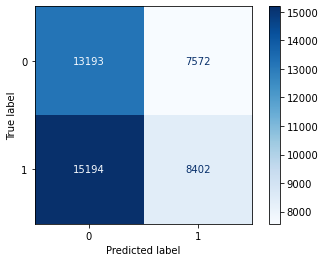

In [45]:
print("Gaussian Naive-Bayes Confusion matrix")
plot_confusion_matrix(gnb_model, X_test_df, scoring_df['y_tt'], cmap=plt.cm.Blues)
plt.show()

In [46]:
portfolio_df['portfolio_sum'] = portfolio_df.sum(axis=1)
portfolio_df.dropna(inplace=True)

In [47]:
portfolio_df

,AWU_returns,AXC_returns,BMG_returns,CHWK_returns,CUU_returns,DLVY_returns,DVRL_returns,EHH_returns,EUZ_returns,EXY_returns,...,XZFM_returns,YPDA_returns,ZEA_returns,ZGL_returns,ZOE_returns,ZWH_returns,ZWNG_returns,ZXGV_returns,ZZQB_returns,portfolio_sum
date,,,,,,,,,,,,,,,,,,,,,
2018-02-09,1014.250066,1015.222766,1000.0,1025.238249,1000.0,1000.0,1009.773202,999.435572,1010.670547,1009.001125,...,1000.0,990.885268,1011.669875,1000.0,1000.0,1000.0,1000.0,1020.565328,1000.000000,93445.221611
2018-02-12,1044.260573,1054.491686,1000.0,1039.129381,1000.0,1000.0,1024.246494,1001.660082,1018.855341,1014.677616,...,1000.0,1016.178649,1021.896054,1000.0,1000.0,1000.0,1000.0,1032.860768,1007.872897,93929.788710
2018-02-13,1060.218019,1053.231202,1000.0,1052.980132,1000.0,1000.0,1027.678305,982.004715,1043.167212,1017.748312,...,1000.0,978.238578,1043.792108,1000.0,1000.0,1000.0,1000.0,1037.455150,1004.519100,94077.044968
2018-02-14,1094.661151,1065.836040,1000.0,1048.174770,1000.0,1000.0,1049.015219,1000.796839,1067.357827,1017.060726,...,1000.0,1012.418822,1070.620789,1000.0,1000.0,1000.0,1000.0,1065.240221,998.152569,94747.831465
2018-02-15,1039.696612,1074.853348,1000.0,1080.116298,1000.0,1000.0,1050.134288,967.694811,1071.238026,1016.627078,...,1000.0,988.492651,1085.298364,1000.0,1000.0,1000.0,1000.0,1075.785420,986.044793,95006.553582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1086.321250,1050.855675,1000.0,1077.733807,1000.0,1000.0,956.654730,487.134367,968.048988,904.984217,...,1000.0,784.892332,822.545717,1000.0,1000.0,1000.0,1000.0,922.551851,1127.046385,98761.042960
2019-12-26,1080.411085,1050.855675,1000.0,1081.489259,1000.0,1000.0,956.654730,482.220525,972.596096,911.238905,...,1000.0,782.613649,822.545717,1000.0,1000.0,1000.0,1000.0,926.358624,1126.250568,98903.405255
2019-12-27,1068.360914,1050.855675,1000.0,1083.306413,1000.0,1000.0,956.654730,474.119327,967.745847,895.815102,...,1000.0,761.991569,822.545717,1000.0,1000.0,1000.0,1000.0,920.626586,1126.421101,98862.171018


In [48]:
portfolio_df_gnb = portfolio_df

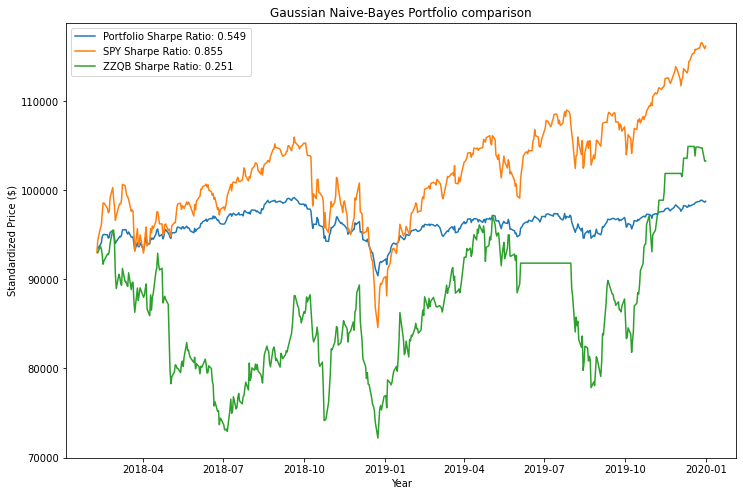

In [49]:
# plot sharpe ratio
# AWU_sharpe = ti.calc_sharpe_ratio(price_series=df_AWU['close'])
# BMG_sharpe = ti.calc_sharpe_ratio(price_series=df_BMG['close'])
# CUU_sharpe = ti.calc_sharpe_ratio(price_series=df_CUU['close'])

plt.figure(figsize=(12,8))
plt.plot(portfolio_df.index, portfolio_df['portfolio_sum'], label = "Portfolio Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(portfolio_df['portfolio_sum']), 3))
plt.plot(backtest_df.index, backtest_df['SPY_portfolio_series'], label = "SPY Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(backtest_df['SPY_portfolio_series']), 3))
plt.plot(portfolio_df.index, portfolio_df['ZZQB_returns']*93, label = "ZZQB Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(portfolio_df['ZZQB_returns']), 3))
plt.xlabel("Year")
plt.ylabel("Standardized Price ($)")
plt.title("Gaussian Naive-Bayes Portfolio comparison")
plt.legend()
plt.show()

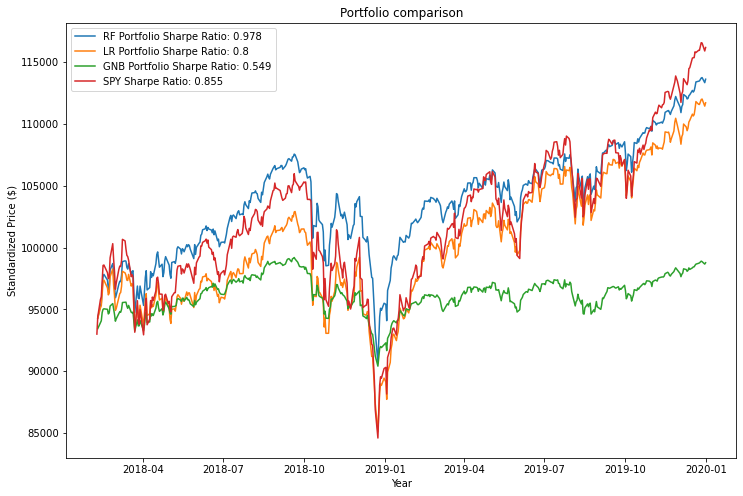

In [50]:
plt.figure(figsize=(12,8))
plt.plot(portfolio_df_rf.index, portfolio_df_rf['portfolio_sum'], label = "RF Portfolio Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(portfolio_df_rf['portfolio_sum']), 3))
plt.plot(portfolio_df_lr.index, portfolio_df_lr['portfolio_sum'], label = "LR Portfolio Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(portfolio_df_lr['portfolio_sum']), 3))
plt.plot(portfolio_df_gnb.index, portfolio_df_gnb['portfolio_sum'], label = "GNB Portfolio Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(portfolio_df_gnb['portfolio_sum']), 3))
plt.plot(backtest_df.index, backtest_df['SPY_portfolio_series'], label = "SPY Sharpe Ratio: %s" %round(ti.calc_sharpe_ratio(backtest_df['SPY_portfolio_series']), 3))
plt.xlabel("Year")
plt.ylabel("Standardized Price ($)")
plt.title("Portfolio comparison")
plt.legend()
plt.show()

In [51]:
backtest_df = backtest_df.iloc[1:]

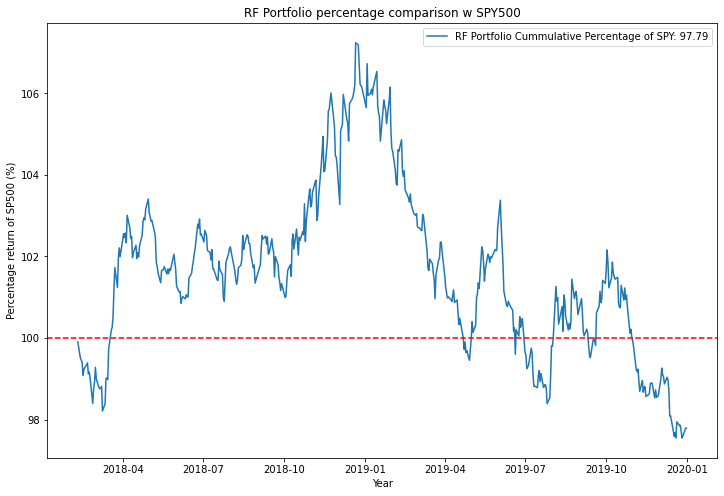

In [72]:
plt.figure(figsize=(12,8))
plt.plot(portfolio_df_rf.index, (portfolio_df_rf['portfolio_sum']/backtest_df['SPY_portfolio_series'])*100,\
         label = "RF Portfolio Cummulative Percentage of SPY: %s" \
         %round((portfolio_df_rf['portfolio_sum'][-1]/backtest_df['SPY_portfolio_series'][-1])*100, 2))
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.xlabel("Year")
plt.ylabel("Percentage return of SP500 (%)")
plt.title("RF Portfolio percentage comparison w SPY500")
plt.legend()
plt.show()

In [79]:
# create dataframe of roc-auc score, final portfolio return, and sharpe ratio for each model and SPY (long-hold)

performance_df = pd.DataFrame(data={'roc_auc': [rf_roc_auc, lr_roc_auc, gnb_roc_auc, 0.5], \
    'Portfolio Return vs SPY (%)': [((portfolio_df_rf['portfolio_sum'][-1] - 93000)/(backtest_df['SPY_portfolio_series'][-1] - 93000))*100, \
                            ((portfolio_df_lr['portfolio_sum'][-1] - 93000)/(backtest_df['SPY_portfolio_series'][-1] - 93000))*100, \
                            ((portfolio_df_gnb['portfolio_sum'][-1] - 93000)/(backtest_df['SPY_portfolio_series'][-1] - 93000))*100, \
                            ((backtest_df['SPY_portfolio_series'][-1] - 93000)/(backtest_df['SPY_portfolio_series'][-1] - 93000))*100], \
                                    'sharpe_ratio': [round(ti.calc_sharpe_ratio(portfolio_df_rf['portfolio_sum']), 3), \
                                                     round(ti.calc_sharpe_ratio(portfolio_df_lr['portfolio_sum']), 3), \
                                                     round(ti.calc_sharpe_ratio(portfolio_df_gnb['portfolio_sum']), 3), \
                                                     round(ti.calc_sharpe_ratio(backtest_df['SPY_portfolio_series']), 3)]}, \
                              index=['Random Forest Classifier', 'Logistic Regression', 'Gaussian Naive-Bayes', 'SPY'])

In [80]:
performance_df

,roc_auc,Portfolio Return vs SPY (%),sharpe_ratio
Random Forest Classifier,0.507091,88.931682,0.978
Logistic Regression,0.501812,80.705589,0.800
Gaussian Naive-Bayes,0.495713,24.900047,0.549
SPY,0.500000,100.000000,0.797
